Gemini connected!
MySQL OK: 1

=== DEMO 1 — Rule-based: cancellation rate by hotel type ===

[Rule-based] USER QUESTION: What is the cancellation rate by hotel type?

Generated SQL:
SELECT 
            h.hotel_type,
            COUNT(*) AS total_bookings,
            SUM(b.is_canceled) AS canceled,
            (SUM(b.is_canceled) / COUNT(*)) * 100 AS cancel_rate
        FROM bookings b
        JOIN hotels h ON b.hotel_id = h.hotel_id
        GROUP BY h.hotel_type; 



,hotel_type,total_bookings,canceled,cancel_rate
0,Resort Hotel,39596,11077.0,27.9750
1,City Hotel,79306,33080.0,41.7119


Rows: 2

=== DEMO 2 — Gemini: cancellation rate by hotel type ===

[Gemini] USER QUESTION: What is the cancellation rate by hotel type?

Generated SQL:
SELECT
  h.hotel_type,
  SUM(CASE WHEN b.is_canceled = 1 THEN 1 ELSE 0 END) / COUNT(b.booking_id) AS cancellation_rate
FROM bookings AS b
JOIN hotels AS h
  ON b.hotel_id = h.hotel_id
GROUP BY
  h.hotel_type; 



,hotel_type,cancellation_rate
0,Resort Hotel,0.2798
1,City Hotel,0.4171


Rows: 2

PLOT:


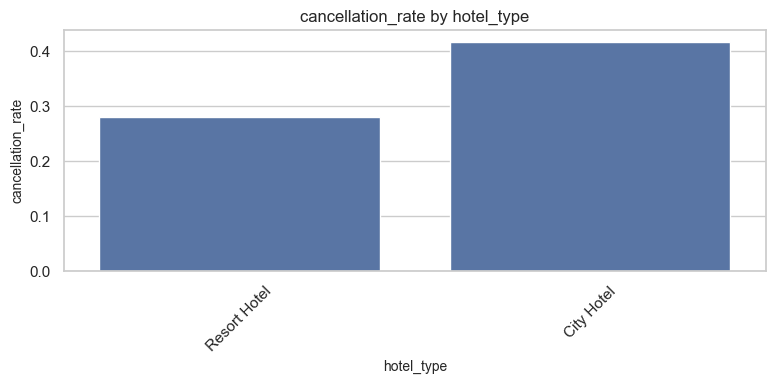


INSIGHT:
Rows: 2, columns: 2.

=== DEMO 3 — Gemini: month with highest bookings ===

[Gemini] USER QUESTION: Which month has the highest number of bookings?

Generated SQL:
SELECT
  b.arrival_date_month
FROM bookings AS b
GROUP BY
  b.arrival_date_month
ORDER BY
  COUNT(b.booking_id) DESC
LIMIT 1; 



,arrival_date_month
0,8


Rows: 1

PLOT:
No suitable numeric/categorical columns for plot.

INSIGHT:
Most bookings in: 8 (≈ 8 bookings).

=== DEMO 4 — Gemini: popular room types ===

[Gemini] USER QUESTION: Which room types are the most popular?

Generated SQL:
SELECT
  r.room_code,
  COUNT(b.booking_id) AS booking_count
FROM bookings AS b
JOIN rooms AS r
  ON b.reserved_room_id = r.room_id
GROUP BY
  r.room_code
ORDER BY
  booking_count DESC; 



,room_code,booking_count
0,A,85601
1,D,19173
2,E,6497
3,F,2890
4,G,2083


Rows: 10

PLOT:


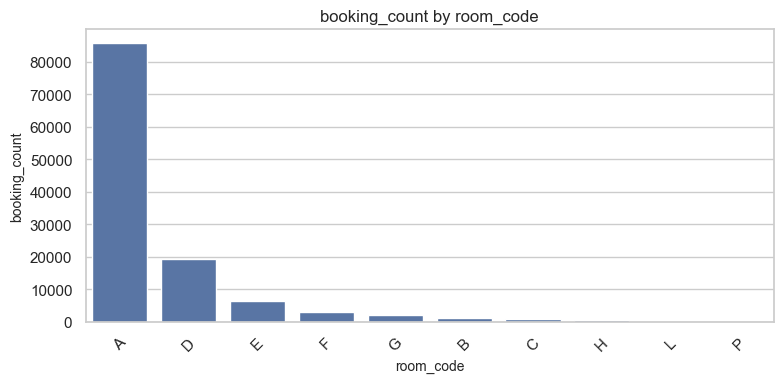


INSIGHT:
Rows: 10, columns: 2.

=== DEMO 5 — Gemini: revenue by market segment ===

[Gemini] USER QUESTION: Which market segment generates the most revenue?

Generated SQL:
SELECT
  ms.market_segment
FROM bookings AS b
JOIN market_segments AS ms
  ON b.market_segment_id = ms.market_segment_id
GROUP BY
  ms.market_segment
ORDER BY
  SUM(b.adr * (b.stays_in_week_nights + b.stays_in_weekend_nights)) DESC
LIMIT 1 



,market_segment
0,Online TA


Rows: 1

PLOT:
No suitable numeric/categorical columns for plot.

INSIGHT:
Rows: 1, columns: 1.


In [2]:
#1) Imports & MySQL connection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
import google.generativeai as genai
from dotenv import load_dotenv
import os

# --- Gemini setup ---
load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)
model = genai.GenerativeModel("models/gemini-2.5-flash")

print("Gemini connected!")

# --- MySQL connection ---
MYSQL_USER = "root"
MYSQL_PASSWORD = "usql12liutop_81"  # твой пароль
MYSQL_HOST = "localhost"
MYSQL_PORT = 3306
MYSQL_DB = "hotel_db"

engine = create_engine(
    f"mysql+pymysql://{MYSQL_USER}:{MYSQL_PASSWORD}"
    f"@{MYSQL_HOST}:{MYSQL_PORT}/{MYSQL_DB}"
)

with engine.connect() as conn:
    print("MySQL OK:", conn.execute(text("SELECT 1")).scalar())

# Немного стилей для графиков
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10


# %% 2) Helper: run_sql
def run_sql(sql: str) -> pd.DataFrame:
    """
    Выполняет SQL в hotel_db и возвращает DataFrame.
    """
    print("SQL:")
    print(sql.strip(), "\n")
    df = pd.read_sql(sql, engine)
    display(df.head())
    print(f"Rows: {len(df)}")
    return df


# %% 3) Reference queries (5 бизнес-проблем)
reference_queries = {

    # 1. Booking Cancellations
    "cancellation_rate_by_hotel": """
        SELECT 
            h.hotel_type,
            COUNT(*) AS total_bookings,
            SUM(b.is_canceled) AS canceled,
            (SUM(b.is_canceled) / COUNT(*)) * 100 AS cancel_rate
        FROM bookings b
        JOIN hotels h ON b.hotel_id = h.hotel_id
        GROUP BY h.hotel_type;
    """,

    # 2. Hotel Occupancy by Month
    "bookings_by_month": """
        SELECT
            b.arrival_date_month,
            h.hotel_type,
            COUNT(*) AS total_bookings
        FROM bookings b
        JOIN hotels h ON b.hotel_id = h.hotel_id
        GROUP BY b.arrival_date_month, h.hotel_type
        ORDER BY b.arrival_date_month, h.hotel_type;
    """,

    # 3. Popular Room Types
    "popular_room_types": """
        SELECT
            r.room_code,
            h.hotel_type,
            COUNT(*) AS total_bookings
        FROM bookings b
        JOIN rooms r ON b.reserved_room_id = r.room_id
        JOIN hotels h ON b.hotel_id = h.hotel_id
        GROUP BY r.room_code, h.hotel_type
        ORDER BY total_bookings DESC;
    """,

    # 4. Revenue by Market Segment
    "revenue_by_market_segment": """
        SELECT
            ms.market_segment,
            h.hotel_type,
            SUM(
                b.adr * (b.stays_in_week_nights + b.stays_in_weekend_nights)
            ) AS revenue
        FROM bookings b
        JOIN hotels h ON b.hotel_id = h.hotel_id
        JOIN market_segments ms 
            ON b.market_segment_id = ms.market_segment_id
        WHERE b.is_canceled = 0
        GROUP BY ms.market_segment, h.hotel_type
        ORDER BY revenue DESC;
    """,

    # 5. Impact of Meal Plans on Bookings (ADR by meal & hotel)
    "adr_by_meal_and_hotel": """
        SELECT 
            m.meal,
            h.hotel_type,
            COUNT(*) AS total_bookings,
            AVG(b.adr) AS avg_adr
        FROM bookings b
        JOIN meals m ON b.meal_id = m.meal_id
        JOIN hotels h ON b.hotel_id = h.hotel_id
        WHERE b.is_canceled = 0
        GROUP BY m.meal, h.hotel_type
        ORDER BY total_bookings DESC;
    """
}


# %% 4) RULE-BASED AI (без LLM) — для надёжности
def question_to_sql_rule_based(question: str) -> str:
    """
    Простая логика: по ключевым словам выбираем один из 5 референс-запросов.
    """

    q = question.lower()

    if "cancel" in q or "отмен" in q:
        return reference_queries["cancellation_rate_by_hotel"]

    if "month" in q or "месяц" in q or "season" in q or "сезон" in q:
        return reference_queries["bookings_by_month"]

    if "room" in q or "комнат" in q or "тип номера" in q:
        return reference_queries["popular_room_types"]

    if "segment" in q or "market" in q or "рынок" in q or "revenue" in q:
        return reference_queries["revenue_by_market_segment"]

    if "meal" in q or "питани" in q or "завтрак" in q or "bb" in q or "hb" in q or "fb" in q or "sc" in q:
        return reference_queries["adr_by_meal_and_hotel"]

    return "SELECT 'Sorry, I do not understand this question yet.' AS message;"


def ask_agent_rule(question: str) -> pd.DataFrame:
    """
    RULE-BASED агент:
    1) текст → выбор готового SQL из reference_queries
    2) выполнение в MySQL
    """
    print(f"\n[Rule-based] USER QUESTION: {question}\n")
    sql = question_to_sql_rule_based(question)
    print("Generated SQL:")
    print(sql.strip(), "\n")

    try:
        df = pd.read_sql(sql, engine)
        display(df.head())
        print(f"Rows: {len(df)}")
        return df
    except Exception as e:
        print("SQL error:", e)
        return pd.DataFrame()


# %% 5) GEMINI: question → SQL (LLM)
def question_to_sql_llm(question: str) -> str:
    """
    Отправляет вопрос к Gemini и возвращает ЧИСТЫЙ SQL (без ```sql ...```).
    """

    prompt = f"""
You are an expert SQL generator for MySQL.

Database structure:
- hotels(h): hotel_id, hotel_type
- rooms(r): room_id, room_code
- meals(m): meal_id, meal
- market_segments(ms): market_segment_id, market_segment
- bookings(b):
    booking_id, hotel_id, reserved_room_id,
    market_segment_id, meal_id,
    arrival_date_year, arrival_date_month,
    stays_in_week_nights, stays_in_weekend_nights,
    is_canceled, adr

RULES:
- Return ONLY one valid MySQL SELECT query.
- NO explanations.
- NO comments.
- NO markdown fences like ```sql.
- Use aliases: b, h, r, m, ms.
- Use ONLY the tables and columns listed above.

User question: {question}
"""

    response = model.generate_content(prompt)
    raw_sql = response.text.strip()
    sql = raw_sql

    # Убираем возможные ``` и 'sql'
    if sql.startswith("```"):
        sql = sql.split("\n", 1)[1].lstrip()
    if sql.lower().startswith("sql"):
        sql = sql[3:].lstrip()
    if sql.endswith("```"):
        sql = sql.rsplit("```", 1)[0].rstrip()

    return sql


# %% 6) Аналитика + графики
def analyze_results(question: str, df: pd.DataFrame) -> str:
    """
    Генерирует простой текстовый инсайт по результатам.
    """
    if df.empty:
        return "Result is empty (0 rows)."

    q = question.lower()
    lines = []

    # Кейс: отмены по типу отеля
    if "cancel" in q and "hotel" in q and "cancel_rate" in df.columns:
        best = df.sort_values("cancel_rate", ascending=False).iloc[0]
        worst = df.sort_values("cancel_rate", ascending=True).iloc[0]
        lines.append(
            f"Highest cancellation rate: {best['hotel_type']} "
            f"≈ {best['cancel_rate']:.1f}%."
        )
        lines.append(
            f"Lowest cancellation rate: {worst['hotel_type']} "
            f"≈ {worst['cancel_rate']:.1f}%."
        )

    # Кейс: месяцы
    if "month" in q and "arrival_date_month" in df.columns:
        value_col = df.select_dtypes(include="number").columns[0]
        top = df.sort_values(value_col, ascending=False).iloc[0]
        lines.append(
            f"Most bookings in: {top['arrival_date_month']} "
            f"(≈ {top[value_col]:.0f} bookings)."
        )

    if not lines:
        lines.append(f"Rows: {len(df)}, columns: {len(df.columns)}.")

    return "\n".join(lines)


def plot_results(question: str, df: pd.DataFrame):
    """
    Строит barplot, если есть 1 категориальный + 1 числовой столбец.
    """
    if df.empty:
        print("Nothing to plot (0 rows).")
        return

    num_cols = df.select_dtypes(include="number").columns.tolist()
    cat_cols = df.select_dtypes(exclude="number").columns.tolist()

    if not num_cols or not cat_cols:
        print("No suitable numeric/categorical columns for plot.")
        return

    x_col = cat_cols[0]
    y_col = num_cols[0]

    plt.figure()
    sns.barplot(x=df[x_col], y=df[y_col])
    plt.xticks(rotation=45)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"{y_col} by {x_col}")
    plt.tight_layout()
    plt.show()


# %% 7) LLM-агент (Gemini → SQL → результат)
def ask_agent_llm(question: str) -> pd.DataFrame:
    """
    LLM-агент:
    1) вопрос → Gemini (генерит SQL)
    2) чистим SQL
    3) выполняем в MySQL
    4) строим график
    5) печатаем инсайт
    """
    print(f"\n[Gemini] USER QUESTION: {question}\n")

    sql = question_to_sql_llm(question)
    print("Generated SQL:")
    print(sql, "\n")

    try:
        df = pd.read_sql(sql, engine)
        display(df.head())
        print(f"Rows: {len(df)}")

        print("\nPLOT:")
        plot_results(question, df)

        print("\nINSIGHT:")
        print(analyze_results(question, df))

        return df

    except Exception as e:
        print("SQL ERROR:", e)
        return pd.DataFrame()


# %% 8) Demo calls (то, что покажешь на защите)
print("\n=== DEMO 1 — Rule-based: cancellation rate by hotel type ===")
df_cancel_rule = ask_agent_rule("What is the cancellation rate by hotel type?")

print("\n=== DEMO 2 — Gemini: cancellation rate by hotel type ===")
df_cancel_llm = ask_agent_llm("What is the cancellation rate by hotel type?")

print("\n=== DEMO 3 — Gemini: month with highest bookings ===")
df_month_llm = ask_agent_llm("Which month has the highest number of bookings?")

print("\n=== DEMO 4 — Gemini: popular room types ===")
df_rooms_llm = ask_agent_llm("Which room types are the most popular?")

print("\n=== DEMO 5 — Gemini: revenue by market segment ===")
df_rev_llm = ask_agent_llm("Which market segment generates the most revenue?")


In [3]:
ask_agent_rule("What is the cancellation rate by hotel type?")



[Rule-based] USER QUESTION: What is the cancellation rate by hotel type?

Generated SQL:
SELECT 
            h.hotel_type,
            COUNT(*) AS total_bookings,
            SUM(b.is_canceled) AS canceled,
            (SUM(b.is_canceled) / COUNT(*)) * 100 AS cancel_rate
        FROM bookings b
        JOIN hotels h ON b.hotel_id = h.hotel_id
        GROUP BY h.hotel_type; 



,hotel_type,total_bookings,canceled,cancel_rate
0,Resort Hotel,39596,11077.0,27.9750
1,City Hotel,79306,33080.0,41.7119


Rows: 2


,hotel_type,total_bookings,canceled,cancel_rate
0,Resort Hotel,39596,11077.0,27.9750
1,City Hotel,79306,33080.0,41.7119



[Gemini] USER QUESTION: What is the cancellation rate by hotel type?

Generated SQL:
SELECT
  h.hotel_type,
  SUM(CASE WHEN b.is_canceled = 1 THEN 1 ELSE 0 END) / COUNT(b.booking_id) AS cancellation_rate
FROM bookings AS b
JOIN hotels AS h
  ON b.hotel_id = h.hotel_id
GROUP BY
  h.hotel_type; 



,hotel_type,cancellation_rate
0,Resort Hotel,0.2798
1,City Hotel,0.4171


Rows: 2

PLOT:


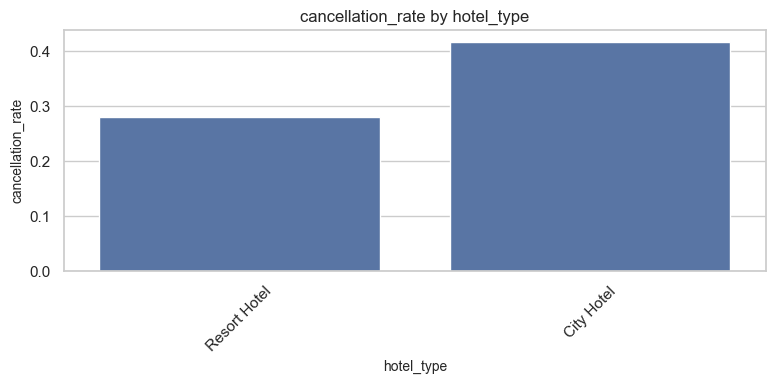


INSIGHT:
Rows: 2, columns: 2.


,hotel_type,cancellation_rate
0,Resort Hotel,0.2798
1,City Hotel,0.4171


In [4]:
ask_agent_llm("What is the cancellation rate by hotel type?")



[Gemini] USER QUESTION: Which room types are the most popular?

Generated SQL:
SELECT
  r.room_code,
  COUNT(b.booking_id) AS booking_count
FROM bookings AS b
JOIN rooms AS r
  ON b.reserved_room_id = r.room_id
GROUP BY
  r.room_code
ORDER BY
  booking_count DESC; 



,room_code,booking_count
0,A,85601
1,D,19173
2,E,6497
3,F,2890
4,G,2083


Rows: 10

PLOT:


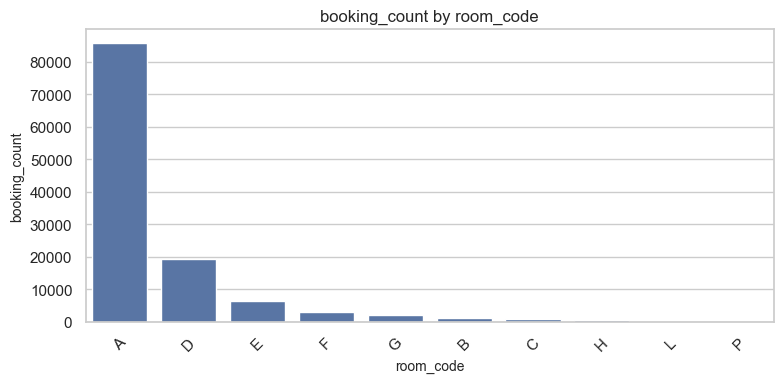


INSIGHT:
Rows: 10, columns: 2.


,room_code,booking_count
0,A,85601
1,D,19173
2,E,6497
3,F,2890
4,G,2083
5,B,1118
6,C,931
7,H,601
8,L,6
9,P,2


In [5]:
ask_agent_llm("Which room types are the most popular?")


[Gemini] USER QUESTION: How do meal plans affect ADR?

Generated SQL:
SELECT
  m.meal,
  AVG(b.adr) AS average_adr
FROM bookings AS b
JOIN meals AS m
  ON b.meal_id = m.meal_id
GROUP BY
  m.meal
ORDER BY
  average_adr DESC; 



,meal,average_adr
0,HB,120.266253
1,FB,109.040476
2,BB,99.613711
3,SC,98.406185
4,Undefined,91.935451


Rows: 5

PLOT:


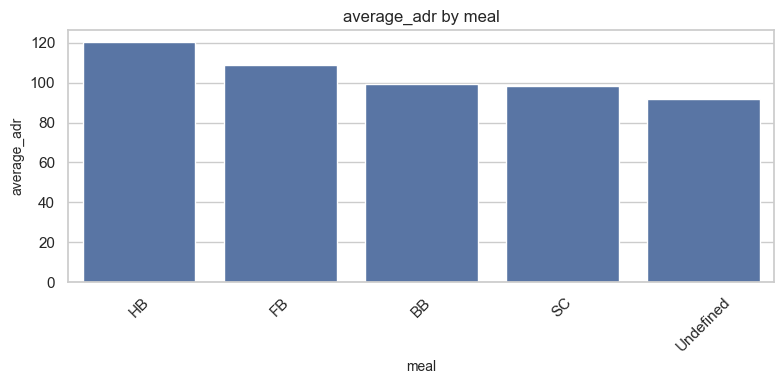


INSIGHT:
Rows: 5, columns: 2.


,meal,average_adr
0,HB,120.266253
1,FB,109.040476
2,BB,99.613711
3,SC,98.406185
4,Undefined,91.935451


In [6]:
ask_agent_llm("How do meal plans affect ADR?")


[Gemini] USER QUESTION: What is the cancellation rate by hotel type?

Generated SQL:
SELECT
  h.hotel_type,
  SUM(CASE WHEN b.is_canceled = 1 THEN 1 ELSE 0 END) / COUNT(b.booking_id) AS cancellation_rate
FROM bookings AS b
JOIN hotels AS h
  ON b.hotel_id = h.hotel_id
GROUP BY
  h.hotel_type; 



,hotel_type,cancellation_rate
0,Resort Hotel,0.2798
1,City Hotel,0.4171


Rows: 2

PLOT:


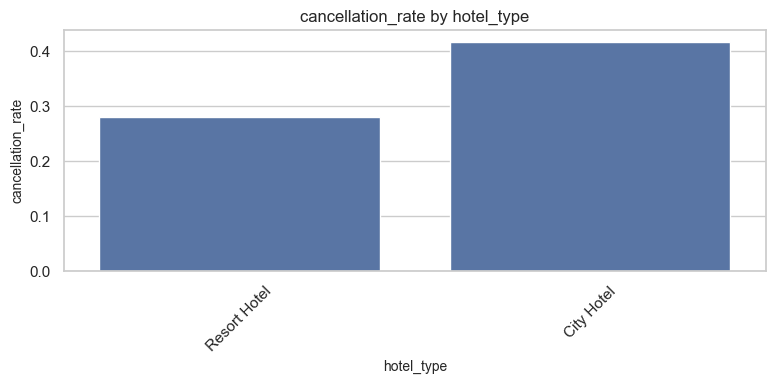


INSIGHT:
Rows: 2, columns: 2.


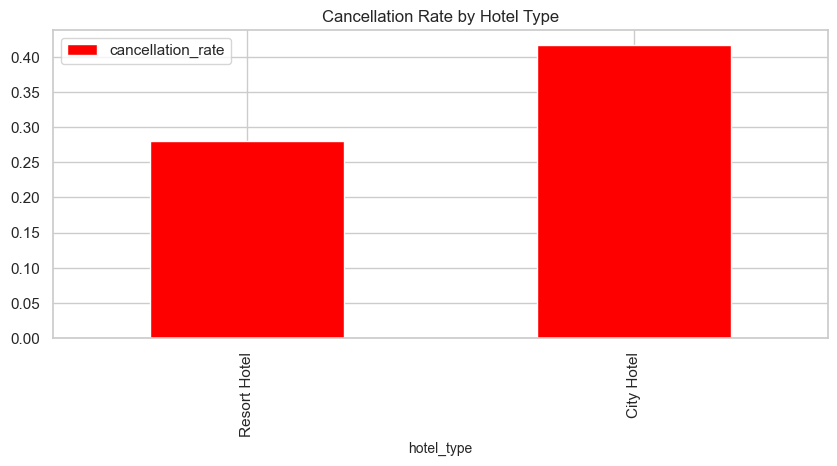

In [8]:
df_cancel = ask_agent_llm("What is the cancellation rate by hotel type?")

df_cancel.plot(
    x="hotel_type",
    y="cancellation_rate",
    kind="bar",
    color="red",
    figsize=(10,4),
    title="Cancellation Rate by Hotel Type"
)
plt.show()


SQL:
SELECT
    ms.market_segment,
    COUNT(*) AS total_bookings
FROM bookings b
JOIN market_segments ms 
    ON b.market_segment_id = ms.market_segment_id
GROUP BY ms.market_segment
ORDER BY total_bookings DESC; 



,market_segment,total_bookings
0,Online TA,56403
1,Offline TA/TO,24160
2,Groups,19806
3,Direct,12449
4,Corporate,5111


Rows: 8


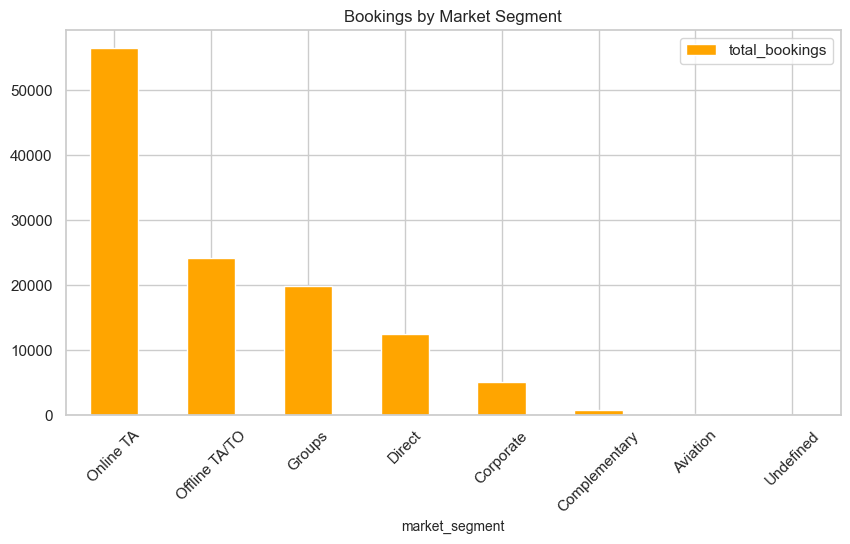

In [5]:
df_segments = run_sql("""
SELECT
    ms.market_segment,
    COUNT(*) AS total_bookings
FROM bookings b
JOIN market_segments ms 
    ON b.market_segment_id = ms.market_segment_id
GROUP BY ms.market_segment
ORDER BY total_bookings DESC;
""")

df_segments.plot(
    x="market_segment",
    y="total_bookings",
    kind="bar",
    figsize=(10,5),
    color="orange",
    title="Bookings by Market Segment"
)
plt.xticks(rotation=45)
plt.show()



[Gemini] USER QUESTION: Which market segments bring the most revenue?

Generated SQL:
SELECT
  ms.market_segment,
  SUM(b.adr * (b.stays_in_week_nights + b.stays_in_weekend_nights)) AS total_revenue
FROM bookings AS b
JOIN market_segments AS ms
  ON b.market_segment_id = ms.market_segment_id
GROUP BY
  ms.market_segment
ORDER BY
  total_revenue DESC; 



,market_segment,total_revenue
0,Online TA,23922846.78
1,Offline TA/TO,8137124.24
2,Direct,5037541.18
3,Groups,4668206.74
4,Corporate,762514.16


Rows: 8

PLOT:


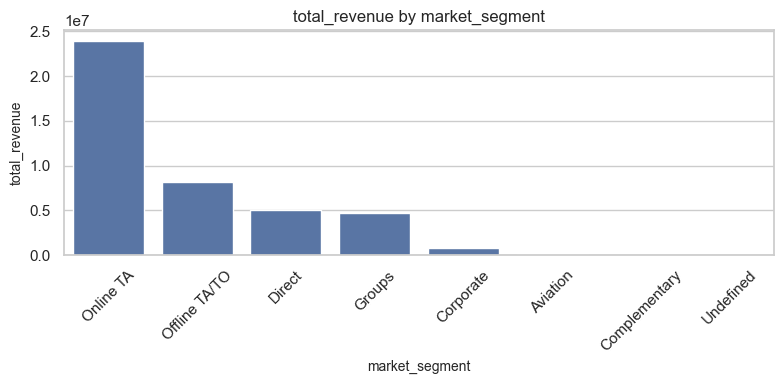


INSIGHT:
Rows: 8, columns: 2.


,market_segment,total_revenue
0,Online TA,23922846.78
1,Offline TA/TO,8137124.24
2,Direct,5037541.18
3,Groups,4668206.74
4,Corporate,762514.16
5,Aviation,87446.36
6,Complementary,5082.52
7,Undefined,48.00


In [7]:
ask_agent_llm("Which market segments bring the most revenue?")


[Gemini] USER QUESTION: What is the average lead time by hotel type?

Generated SQL:
SELECT
  h.hotel_type,
  AVG(b.stays_in_week_nights + b.stays_in_weekend_nights)
FROM bookings AS b
JOIN hotels AS h
  ON b.hotel_id = h.hotel_id
GROUP BY
  h.hotel_type 



,hotel_type,AVG(b.stays_in_week_nights + b.stays_in_weekend_nights)
0,Resort Hotel,4.3379
1,City Hotel,2.9782


Rows: 2

PLOT:


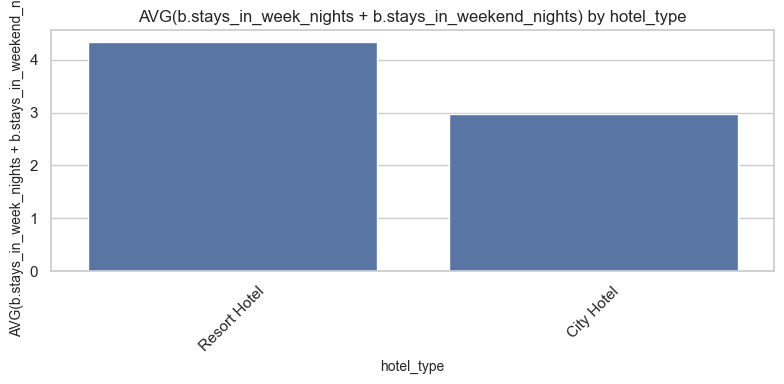


INSIGHT:
Rows: 2, columns: 2.


In [8]:
df_lead = ask_agent_llm("What is the average lead time by hotel type?")

In [9]:
pd.read_sql("SHOW TABLES;", engine)


,Tables_in_hotel_db
0,bookings
1,customers
2,deposit_types
3,distribution_channels
4,hotels
5,market_segments
6,meals
7,rooms



[Gemini] USER QUESTION: Which room types are the most popular?

Generated SQL:
SELECT
  r.room_code,
  COUNT(b.booking_id) AS num_bookings
FROM bookings AS b
JOIN rooms AS r
  ON b.reserved_room_id = r.room_id
GROUP BY
  r.room_code
ORDER BY
  num_bookings DESC; 



,room_code,num_bookings
0,A,85601
1,D,19173
2,E,6497
3,F,2890
4,G,2083


Rows: 10

PLOT:


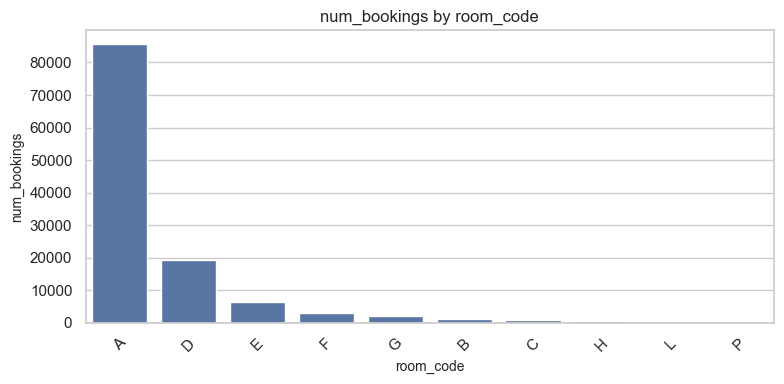


INSIGHT:
Rows: 10, columns: 2.


,room_code,num_bookings
0,A,85601
1,D,19173
2,E,6497
3,F,2890
4,G,2083
5,B,1118
6,C,931
7,H,601
8,L,6
9,P,2


In [10]:
ask_agent_llm("Which room types are the most popular?")

In [3]:
ask_agent_rule("What is the cancellation rate by hotel type?")


[Rule-based] USER QUESTION: What is the cancellation rate by hotel type?

Generated SQL:
SELECT 
            h.hotel_type,
            COUNT(*) AS total_bookings,
            SUM(b.is_canceled) AS canceled,
            (SUM(b.is_canceled) / COUNT(*)) * 100 AS cancel_rate
        FROM bookings b
        JOIN hotels h ON b.hotel_id = h.hotel_id
        GROUP BY h.hotel_type; 



,hotel_type,total_bookings,canceled,cancel_rate
0,Resort Hotel,39596,11077.0,27.9750
1,City Hotel,79306,33080.0,41.7119


Rows: 2


,hotel_type,total_bookings,canceled,cancel_rate
0,Resort Hotel,39596,11077.0,27.9750
1,City Hotel,79306,33080.0,41.7119


In [2]:
ask_agent_rule("What is the cancellation rate by hotel type?")


[Rule-based] USER QUESTION: What is the cancellation rate by hotel type?

Generated SQL:
SELECT 
            h.hotel_type,
            COUNT(*) AS total_bookings,
            SUM(b.is_canceled) AS canceled,
            (SUM(b.is_canceled) / COUNT(*)) * 100 AS cancel_rate
        FROM bookings b
        JOIN hotels h ON b.hotel_id = h.hotel_id
        GROUP BY h.hotel_type; 



,hotel_type,total_bookings,canceled,cancel_rate
0,Resort Hotel,39596,11077.0,27.9750
1,City Hotel,79306,33080.0,41.7119


Rows: 2


,hotel_type,total_bookings,canceled,cancel_rate
0,Resort Hotel,39596,11077.0,27.9750
1,City Hotel,79306,33080.0,41.7119


In [3]:
ask_agent_llm("Which month has the highest number of bookings?")


[Gemini] USER QUESTION: Which month has the highest number of bookings?

Generated SQL:
SELECT
  b.arrival_date_month
FROM bookings AS b
GROUP BY
  b.arrival_date_month
ORDER BY
  COUNT(b.booking_id) DESC
LIMIT 1; 



,arrival_date_month
0,8


Rows: 1

PLOT:
No suitable numeric/categorical columns for plot.

INSIGHT:
Most bookings in: 8 (≈ 8 bookings).


,arrival_date_month
0,8



[Gemini] USER QUESTION: Which room types are the most popular?

Generated SQL:
SELECT r.room_code, COUNT(b.booking_id) AS booking_count
FROM bookings AS b
JOIN rooms AS r
ON b.reserved_room_id = r.room_id
GROUP BY r.room_code
ORDER BY booking_count DESC; 



,room_code,booking_count
0,A,85601
1,D,19173
2,E,6497
3,F,2890
4,G,2083


Rows: 10

PLOT:


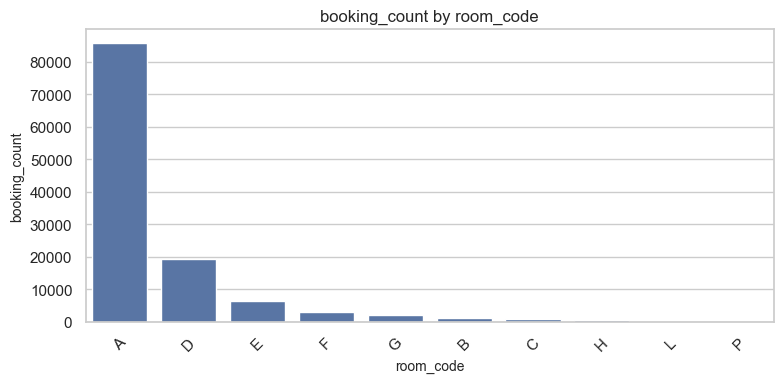


INSIGHT:
Rows: 10, columns: 2.


,room_code,booking_count
0,A,85601
1,D,19173
2,E,6497
3,F,2890
4,G,2083
5,B,1118
6,C,931
7,H,601
8,L,6
9,P,2


In [4]:
ask_agent_llm("Which room types are the most popular?")

In [6]:
ask_agent_llm("Which market segment generates the most revenue?")


[Gemini] USER QUESTION: Which market segment generates the most revenue?

Generated SQL:
SELECT
  ms.market_segment
FROM bookings AS b
JOIN market_segments AS ms
  ON b.market_segment_id = ms.market_segment_id
GROUP BY
  ms.market_segment
ORDER BY
  SUM(b.adr * (b.stays_in_week_nights + b.stays_in_weekend_nights)) DESC
LIMIT 1 



,market_segment
0,Online TA


Rows: 1

PLOT:
No suitable numeric/categorical columns for plot.

INSIGHT:
Rows: 1, columns: 1.


,market_segment
0,Online TA



[Gemini] USER QUESTION: How do meal plans affect ADR for each hotel type?

Generated SQL:
SELECT
  h.hotel_type,
  m.meal,
  AVG(b.adr) AS average_adr
FROM bookings AS b
JOIN hotels AS h
  ON b.hotel_id = h.hotel_id
JOIN meals AS m
  ON b.meal_id = m.meal_id
GROUP BY
  h.hotel_type,
  m.meal
ORDER BY
  h.hotel_type,
  m.meal; 



,hotel_type,meal,average_adr
0,City Hotel,BB,104.876270
1,City Hotel,FB,76.397727
2,City Hotel,HB,120.055281
3,City Hotel,SC,99.121259
4,Resort Hotel,BB,88.531166


Rows: 9

PLOT:


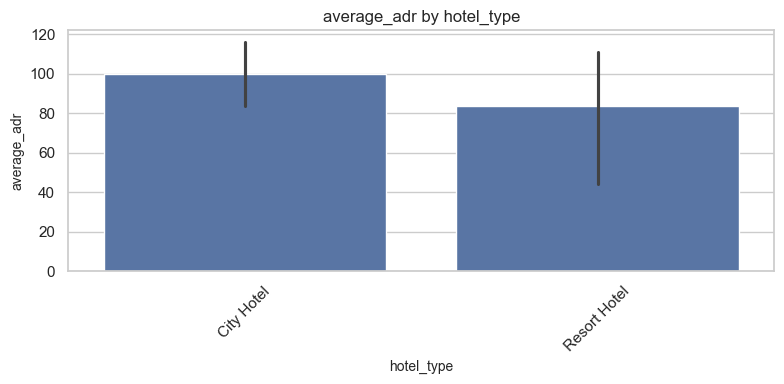


INSIGHT:
Rows: 9, columns: 3.


,hotel_type,meal,average_adr
0,City Hotel,BB,104.876270
1,City Hotel,FB,76.397727
2,City Hotel,HB,120.055281
3,City Hotel,SC,99.121259
4,Resort Hotel,BB,88.531166
5,Resort Hotel,FB,110.945358
6,Resort Hotel,HB,120.435120
7,Resort Hotel,SC,6.353537
8,Resort Hotel,Undefined,91.935451


In [7]:
ask_agent_llm("How do meal plans affect ADR for each hotel type?")

In [3]:
df_dist = ask_agent_llm("Which distribution channel has the highest number of bookings?")


[Gemini] USER QUESTION: Which distribution channel has the highest number of bookings?

Generated SQL:
SELECT
  ms.market_segment
FROM bookings AS b
JOIN market_segments AS ms
  ON b.market_segment_id = ms.market_segment_id
GROUP BY
  ms.market_segment
ORDER BY
  COUNT(b.booking_id) DESC
LIMIT 1; 



,market_segment
0,Online TA


Rows: 1

PLOT:
No suitable numeric/categorical columns for plot.

INSIGHT:
Rows: 1, columns: 1.



[Gemini] USER QUESTION: What is the cancellation rate by hotel type?

Generated SQL:
SELECT
  h.hotel_type,
  SUM(b.is_canceled) / COUNT(b.booking_id) AS cancellation_rate
FROM bookings AS b
JOIN hotels AS h
  ON b.hotel_id = h.hotel_id
GROUP BY
  h.hotel_type; 



,hotel_type,cancellation_rate
0,Resort Hotel,0.2798
1,City Hotel,0.4171


Rows: 2

PLOT:


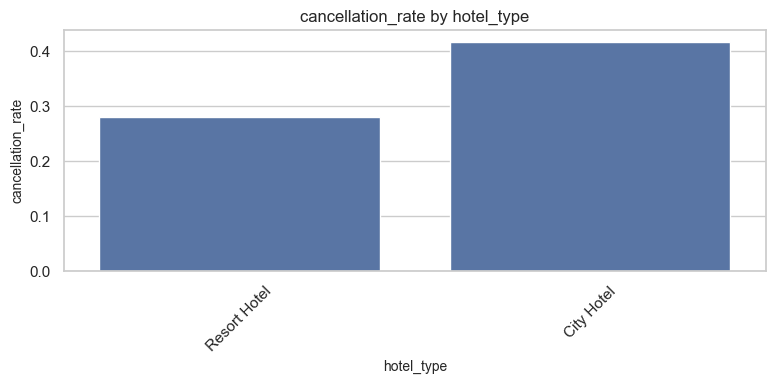


INSIGHT:
Rows: 2, columns: 2.


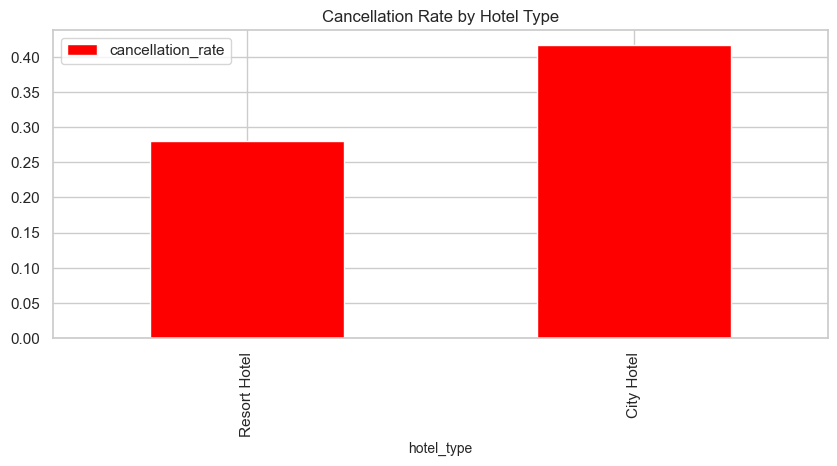

In [4]:
df_cancel = ask_agent_llm("What is the cancellation rate by hotel type?")

df_cancel.plot(
    x="hotel_type",
    y="cancellation_rate",
    kind="bar",
    color="red",
    figsize=(10,4),
    title="Cancellation Rate by Hotel Type"
)
plt.show()


[Gemini] USER QUESTION: Show bookings by market segment

Generated SQL:
SELECT
  ms.market_segment,
  COUNT(b.booking_id) AS total_bookings
FROM bookings AS b
JOIN market_segments AS ms
  ON b.market_segment_id = ms.market_segment_id
GROUP BY
  ms.market_segment
ORDER BY
  total_bookings DESC; 



,market_segment,total_bookings
0,Online TA,56403
1,Offline TA/TO,24160
2,Groups,19806
3,Direct,12449
4,Corporate,5111


Rows: 8

PLOT:


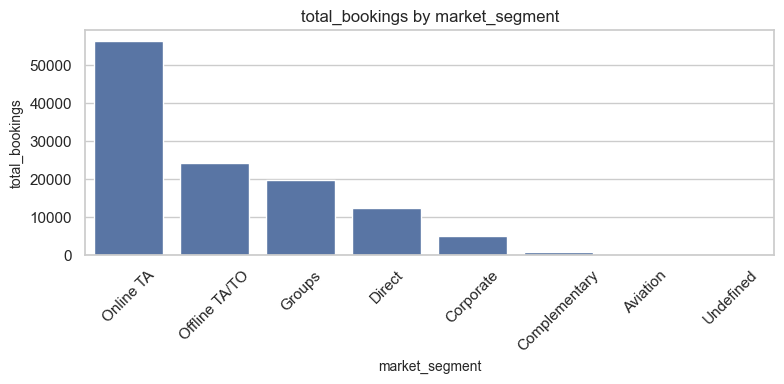


INSIGHT:
Rows: 8, columns: 2.


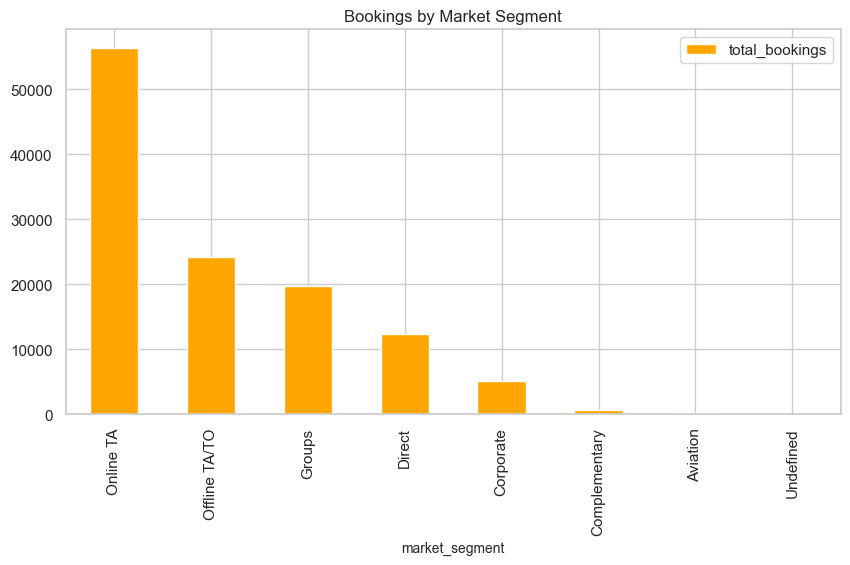

In [6]:
df_segments = ask_agent_llm("Show bookings by market segment")

df_segments.plot(
    x="market_segment",
    y="total_bookings",
    kind="bar",
    figsize=(10,5),
    color="orange",
    title="Bookings by Market Segment"
)
plt.show()